# SMS Spam-Ham Classification

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("SMSSpamCollection",sep='\t',names=['label','message'])  #Reading the file using separator as 'Tab'

In [3]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df.info()    #Checking null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.isnull().values.any()

False

So there are no null and 'NaN' values. We can proceed further to check if the dataset is imbalanced or not

In [7]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [8]:
747/4825

0.15481865284974095

In [9]:
# Importing essential libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

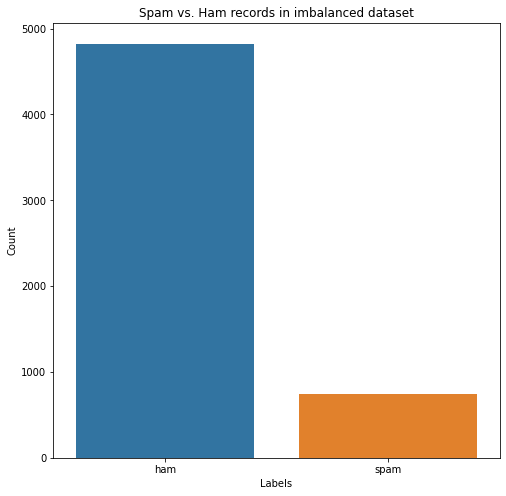

In [10]:
plt.figure(figsize=(8,8))
sns.countplot(x='label', data=df)
plt.title('Spam vs. Ham records in imbalanced dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

So it looks like the dataset is imbalanced as we have less 'spam' records. We will handle this using oversampling later

## Feature Engineering

### Converting target variable 'label' into binary

In [11]:
main_df = df.copy()
main_df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
main_df['label'] = main_df['label'].apply(lambda x : 0 if x.lower()== 'ham' else 1)

In [13]:
main_df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Data Preparation

### Making data preprocessing function

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [15]:
preprocessed_corpus = []
def preprocessData(column):
    lemma = WordNetLemmatizer()
    for i in range(len(column)):
        review = re.sub('\W', ' ',column[i])
        review = review.lower()
        review = review.split()
        review = [lemma.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
        review = ' '.join(review)
        preprocessed_corpus.append(review)

In [16]:
preprocessData(main_df['message'])

In [17]:
preprocessed_corpus[0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

Here we can see that our data is processed. Now we have to convert data into numerical values to feed the model

### Using Tf-Idf Vectorizer for converting data into numerical values

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
vectorize = TfidfVectorizer()
X = vectorize.fit_transform(preprocessed_corpus).toarray()

In [20]:
import pickle
pickle.dump(vectorize, open('tranform.pkl', 'wb'))

In [21]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y = main_df.pop('label')

In [23]:
print(X.shape,y.shape)

(5572, 8054) (5572,)


In [24]:
from collections import Counter
print('Dataset shape {}'.format(Counter(y)))

Dataset shape Counter({0: 4825, 1: 747})


### Now we will handle imbalancing using over-sampling through imblearn module

In [25]:
from imblearn.over_sampling import RandomOverSampler   #Library for over-sampling
sampler = RandomOverSampler(sampling_strategy=0.5)
X_bal,y_bal = sampler.fit_resample(X,y)

In [26]:
from collections import Counter
print('Original Dataset shape {}'.format(Counter(y)))
print('Balanced Dataset shape {}'.format(Counter(y_bal)))

Original Dataset shape Counter({0: 4825, 1: 747})
Balanced Dataset shape Counter({0: 4825, 1: 2412})


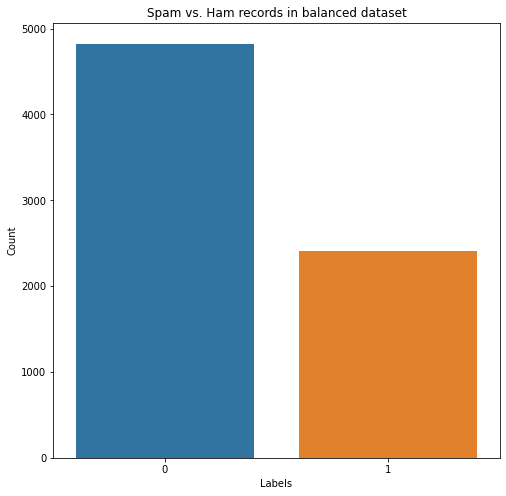

In [27]:
plt.figure(figsize=(8,8))
sns.countplot(x=y_bal)
plt.title('Spam vs. Ham records in balanced dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Now we have a balanced dataset.We can feed this to our model now

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.35, random_state=0, stratify=y_bal)

### Naive Bayes model

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

In [30]:
NBclassifier = MultinomialNB()
stratified_cv = StratifiedKFold(n_splits = 5)
params = {'alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
NBmodel = GridSearchCV(estimator = NBclassifier,
                     param_grid=params,
                     cv = stratified_cv,
                     scoring = 'recall',
                     verbose = 1,
                     n_jobs=-1)

In [31]:
NBmodel.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0]},
             scoring='recall', verbose=1)

In [32]:
print("Best Recall: ", NBmodel.best_score_)
print("Best alpha value: ", NBmodel.best_params_)

Best Recall:  0.984060153436031
Best alpha value:  {'alpha': 0.1}


In [33]:
NBclassifier_final = MultinomialNB(alpha = 0.1)
NBclassifier_final.fit(X_train,y_train)

MultinomialNB(alpha=0.1)

In [34]:
y_pred_NB = NBclassifier_final.predict(X_test)
y_pred_NB

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [35]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred_NB))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1689
           1       0.98      0.97      0.97       844

    accuracy                           0.98      2533
   macro avg       0.98      0.98      0.98      2533
weighted avg       0.98      0.98      0.98      2533



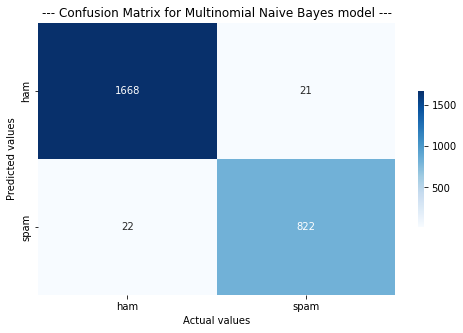

In [36]:
# Confusion matrix of MNB model
cm = confusion_matrix(y_test, y_pred_NB)

plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
p = plt.xlabel('Actual values')
p = plt.ylabel('Predicted values')
p = plt.title('--- Confusion Matrix for Multinomial Naive Bayes model ---')


### RandomForests model

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
classifier_RF = RandomForestClassifier()
params_RF = {'n_estimators' : [10,15,20,25,30]}
model_RF = GridSearchCV(estimator = classifier_RF,
                     param_grid = params_RF,
                     cv = stratified_cv,
                     scoring = 'recall',
                     verbose = 1,
                     n_jobs=-1)

In [39]:
model_RF.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 15, 20, 25, 30]},
             scoring='recall', verbose=1)

In [40]:
print("Best Recall for RF: ", model_RF.best_score_)
print("Best number of estimators: ", model_RF.best_params_)

Best Recall for RF:  0.974499908426772
Best number of estimators:  {'n_estimators': 25}


In [41]:
classifier_RF_final = RandomForestClassifier(n_estimators=model_RF.best_params_['n_estimators'])

In [42]:
classifier_RF_final.fit(X_train,y_train)

RandomForestClassifier(n_estimators=25)

In [43]:
y_pred_RF = classifier_RF_final.predict(X_test)
y_pred_RF

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [44]:
print(classification_report(y_test,y_pred_RF))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1689
           1       1.00      0.99      0.99       844

    accuracy                           0.99      2533
   macro avg       0.99      0.99      0.99      2533
weighted avg       0.99      0.99      0.99      2533



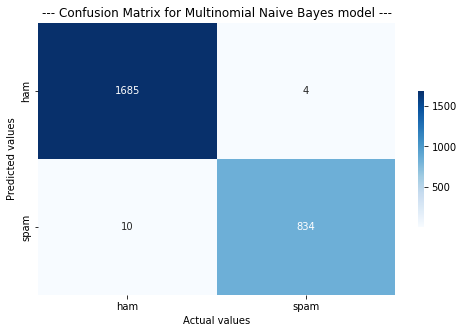

In [45]:
# Confusion matrix of RF model
cm = confusion_matrix(y_test, y_pred_RF)

plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
p = plt.xlabel('Actual values')
p = plt.ylabel('Predicted values')
p = plt.title('--- Confusion Matrix for Multinomial Naive Bayes model ---')

So we have got better results in RandomForestsClassifier. We will save this model for later use

### Making Sample predictions

In [46]:
def predict(sample_msg):
    lemma = WordNetLemmatizer()
    review = re.sub('\W', ' ',sample_msg)
    review = review.lower()
    review = review.split()
    review = [lemma.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    
    final_review = vectorize.transform([review]).toarray()
    print(final_review)
    prediction = classifier_RF_final.predict(final_review)
    print(prediction)

In [47]:
sample_message = 'IMPORTANT - You could be entitled up to £3,160 in compensation from mis-sold PPI on a credit card or loan. Please reply PPI for info or STOP to opt out.'
predict(sample_message)

[[0. 0. 0. ... 0. 0. 0.]]
[1]


In [48]:
pickle.dump(classifier_RF_final, open('model.pkl', 'wb'))

In [49]:
predict("Ok lar... Joking wif u oni...")

[[0. 0. 0. ... 0. 0. 0.]]
[0]


In [50]:
predict("Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030")

[[0. 0. 0. ... 0. 0. 0.]]
[1]


So our model is predicting fine!!!!